In [1]:
!pip install pandas                      # (29 sec)
!pip install sklearn
!pip install matplotlib
!pip install chart_studio
!pip install plotly
!pip install wordninja
!pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
import wordninja
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('brown')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
# check memory usage
import pandas as pd
import sys

def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")

def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v) for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

In [4]:
#Import Packages to implement Gensim FastText

import pandas as pd
import numpy as np
import re
from tqdm import tqdm
 
import nltk
en_stop = set(nltk.corpus.stopwords.words('english'))

from gensim.models.fasttext import FastText

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
 
# Lemmatization
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

##Data Pre-processing

In [ ]:
# Read dataset
Domains_df = pd.read_csv('/content/drive/MyDrive/ML/Data/Cleaned Data/Copy of DomainMergedFile.csv') # (7 sec)
#Domains_df = pd.read_excel("/content/more_sales_data.xlsx", nrows=1000) #, nrows=5000

Domains_df = Domains_df.loc[:, ~Domains_df.columns.str.contains('^Unnamed')]

print('List of all columns')
print(list(Domains_df))

# Checking for missing values in our dataframe
# No there is no missing value
Domains_df.isnull().sum()

# may be empty host - check
Domains_df['Domain'].replace('', np.nan, inplace=True)
Domains_df.dropna(subset=['Domain'], inplace=True)

List of all columns
['Domain', 'category']


In [ ]:
len(Domains_df)

8708039

In [ ]:
Domains_df.describe()

,category
count,8.708039e+06
mean,1.169290e+00
std,8.032742e-01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+01


In [ ]:
Domains_df['category']

0          10
1          10
2          10
3          10
4          10
           ..
8708034     3
8708035     3
8708036     3
8708037     3
8708038     3
Name: category, Length: 8708039, dtype: int64

In [31]:
Domains_df.groupby('category').size()

category
1    8324667
2     228812
3     107533
4      35226
5      10298
dtype: int64

Step1: Convert text column into list and subset


In [ ]:
#Step1: Convert text column into list and subset

# Subset data for gensim fastText model
all_sent = list(Domains_df['Domain'])
some_sent = all_sent[0:]
some_sent[0:10]

['andyburd.com',
 'musicals.com',
 'cultura.com',
 'ifly.com',
 'mirror.com',
 'cleanenergy.com',
 'cairo.com',
 'harmony.com',
 'miss.com',
 'lh.com']

In [ ]:
#sliptting the top-level domain from domain name              # (15 sec)
Domains_df['clean'] = Domains_df['Domain'].str.replace('.com', '')
Domains_df['clean'] = Domains_df['clean'].str.replace('-', '')

# may be empty clean - check
Domains_df['clean'].replace('', np.nan, inplace=True)
Domains_df.dropna(subset=['clean'], inplace=True)

df_clean= Domains_df[['clean']]
df_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,clean
0,andyburd
1,musicals
2,cultura
3,ifly
4,mirror


Step2: Text Cleaning & data preparation


In [ ]:
clean_corpus = Domains_df['clean'].tolist()          # (24 sec)
 
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]

100%|██████████| 8708035/8708035 [00:31<00:00, 272562.53it/s]


#Train fastText word embeddings python

In [ ]:
# # Defining values for parameters                                (1hr & 30mins for full data)
embedding_size = 200    #( NEW : 1hr & 5mins for full data)
window_size = 5         #(Max distance b/W the current and predicted word within a sentence)
min_word = 1
down_sampling = 1e-2    #(reducing the high frequency words - effecting the whole Model)

# #%%time
# fast_Text_model = FastText(word_tokens,
#                       vector_size=embedding_size,
#                       window=window_size,
#                       min_count=min_word,
#                       sample=down_sampling,
#                       workers = 8,      #(Use these many worker threads to train the model (=faster training with multicore machines)
#                       sg=1,
#                       epochs=100) #50

#Save & Load Gensim fastText word embeddings Python model

In [ ]:
# Save fastText gensim model #24 hours
# fast_Text_model.save("/content/drive/MyDrive/ML/Data/FullEmbeddingModel/model")

In [ ]:
from gensim.models.fasttext import FastText

# from gensim.models import              #(19 mins)
# Load saved gensim fastText model
fast_Text_model = FastText.load("/content/drive/MyDrive/ML/Data/FullEmbeddingModel/model")

#Explore Gensim fastText model

In [ ]:
# most_similar_dict = 
fast_Text_model.wv.most_similar([Domains_df['clean'][0], Domains_df['clean'][1]], topn=10)

[('shadelands', 0.9999578595161438),
 ('bellandsaints', 0.9999574422836304),
 ('andyandersonbooks', 0.9999574422836304),
 ('portlandsports', 0.9999569654464722),
 ('machineworldoman', 0.9999567866325378),
 ('creativegourmethospitality', 0.9999567270278931),
 ('virtualrealitysydney', 0.9999563694000244),
 ('masterchangswoodlands', 0.9999560117721558),
 ('christianmusicandbooks', 0.9999558329582214),
 ('greenstickermotorsports', 0.9999558329582214)]

In [ ]:
# Check top 10 simila0r word for a given word by gensim fastText
top_sim_count = 10

result = fast_Text_model.wv.most_similar('oet', topn=10)
print(result)

def most_similar(row):
  index = 1
  for embed in fast_Text_model.wv.most_similar(row['clean'], topn=10):
    row['sim-' + str(index)] = embed
    index += 1
  # row['clean-test'] = row['clean'] + 'test'
  return row

# Domains_df = Domains_df.apply(most_similar, axis=1, raw=True)

applied_df = Domains_df.apply(lambda row: most_similar(row), axis='columns', result_type='expand')
df = pd.concat([Domains_df, applied_df], axis='columns')

from numba import njit

# @njit
# def test(c, ind):
#   res = np.empty(c.shape)
#   for i in range(len(c)):
#     res[i] = fast_Text_model.wv.most_similar(i, topn=10)[ind]
#   return res

# for index in range(1, top_sim_count + 1):
#   Domains_df['sim-' + str(index)] = test(Domains_df['clean'].values, index)

# Domains_df.head()

In [ ]:
# Most opposite to a word

# fast_Text_model.wv.most_similar(negative=["oet"], topn=10)

def most_dissimilar(row):
  index = 1
  for embed in fast_Text_model.wv.most_similar(negative=[row['clean']], topn=10):
    row['dissim-' + str(index)] = embed
    index += 1
  return row

Domains_df = Domains_df.apply(most_dissimilar, axis=1, raw=True)
Domains_df.head()


In [ ]:
# word_vectors = pd.DataFrame(fast_Text_model.wv.get_normed_vectors())
embedding_df = pd.DataFrame(fast_Text_model.wv.get_normed_vectors())

In [ ]:
len(fast_Text_model.wv.index_to_key)
embedding_df['clean'] = fast_Text_model.wv.index_to_key

In [ ]:
%timeit
print(len(embedding_df))
embedding_df.head()

8658791


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,clean
0,-0.033800,0.071080,0.029198,0.149566,-0.075402,-0.091470,0.115529,0.169332,-0.034737,-0.021635,...,-0.029600,0.018230,-0.064437,0.015064,0.019278,0.057879,-0.019038,-0.104372,-0.028322,.
1,-0.027282,0.075368,0.024452,0.153773,-0.072697,-0.090155,0.112354,0.172259,-0.034639,-0.014502,...,-0.030548,0.007523,-0.067208,0.013828,0.025034,0.046207,-0.025020,-0.098995,-0.025869,au
2,-0.028039,0.075375,0.024407,0.153475,-0.072563,-0.089810,0.112105,0.172286,-0.034864,-0.014603,...,-0.029993,0.007806,-0.067004,0.014000,0.025071,0.047095,-0.025197,-0.099344,-0.026044,br
3,-0.023592,0.077244,0.021901,0.155733,-0.071094,-0.089240,0.110181,0.173943,-0.034854,-0.011230,...,-0.030961,0.001269,-0.068418,0.012671,0.027574,0.039503,-0.028526,-0.096208,-0.024584,ar
4,-0.029058,0.075200,0.026031,0.152727,-0.072798,-0.090893,0.113186,0.171641,-0.034883,-0.015811,...,-0.029671,0.010097,-0.066413,0.013864,0.023058,0.049667,-0.023754,-0.100121,-0.026126,mx


In [ ]:
Domains_df = Domains_df.merge(embedding_df, on='clean')

In [ ]:
Domains_df.to_csv('/content/drive/MyDrive/ML/Data/FinalWordEmbeddingData.csv')

In [ ]:
memory_usage()

,Size
en_stop,8.23KB
MLPClassifier,1.96KB
_,1.27KB
_6,1.27KB
tqdm,1.04KB
PCA,1.04KB
TSNE,1.04KB
FastText,1.04KB
WordNetLemmatizer,1.04KB
_i4,867.00B


In [ ]:
import gc

gc.get_count()
gc.collect()
gc.get_count()

(23, 0, 0)

In [ ]:
# Dimension must be 300
1

In [ ]:
# Check top 10 similarity score between two word

# fast_Text_model.wv.similarity('oet', 'gbr') andyburd musicals
# fast_Text_model.wv.similarity('andyburd', 'musicals')  


###word embeddings visualization

In [ ]:
# tsne plot for below word
# for_word = 'food'
def tsne_plot(for_word, w2v_model):
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
 
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
 
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
 
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)
 
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
 
    #---------------------- Apply PCA and tsne to reduce dimention --------------
 
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
 
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
 
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})
 
    #------------------------- tsne plot Python -----------------------------------
 
    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
 
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
 
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


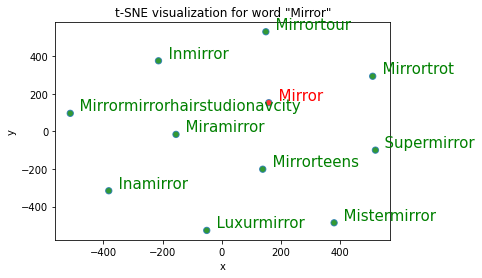

In [ ]:
# tsne plot for top 10 similar word to 'mirror'

tsne_plot(for_word='mirror', w2v_model=fast_Text_model)


#start here Classifiers (DT, MLP, AdaBoost )

In [5]:
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
Domains_df = pd.read_csv('/content/drive/MyDrive/ML/Data/FinalWordEmbeddingData.csv') #( 9 mins )

In [ ]:
# Domains_df = Domains_df.loc[:, ~Domains_df.columns.str.contains('^Unnamed')]

In [7]:
# reduce categories
import math
import numpy as np

Domains_df['category'] = np.int16((Domains_df.category - 1) / 2) + 1

In [8]:
# testing what we are sending (with or without sim, dissim)
Domains_df.head()

,Unnamed: 0,Domain,category,clean,0,1,2,3,4,5,...,190,191,192,193,194,195,196,197,198,199
0,0,andyburd.com,5,andyburd,-0.005076,0.088944,0.010243,0.161200,-0.062638,-0.083003,...,-0.060129,-0.032500,-0.026517,-0.073724,0.008848,0.042910,0.009688,-0.044145,-0.079197,-0.016259
1,1,andyburd.com,1,andyburd,-0.005076,0.088944,0.010243,0.161200,-0.062638,-0.083003,...,-0.060129,-0.032500,-0.026517,-0.073724,0.008848,0.042910,0.009688,-0.044145,-0.079197,-0.016259
2,2,musicals.com,5,musicals,-0.008845,0.086487,0.010999,0.160533,-0.063612,-0.084416,...,-0.062294,-0.031787,-0.022307,-0.073013,0.009879,0.040297,0.012152,-0.040955,-0.081759,-0.018112
3,3,cultura.com,5,cultura,-0.009780,0.085412,0.012876,0.162514,-0.063820,-0.083399,...,-0.061177,-0.032091,-0.021701,-0.072460,0.010204,0.040167,0.014215,-0.040572,-0.082235,-0.017618
4,4,ifly.com,5,ifly,-0.004515,0.082289,0.012891,0.165094,-0.058303,-0.083498,...,-0.061289,-0.032605,-0.029644,-0.079427,0.009998,0.038276,0.007558,-0.043310,-0.074116,-0.010005


In [ ]:
# from sklearn.preprocessing import LabelEncoder  #(1 min) ###### not sure about this cell

# clean_encoder = LabelEncoder()
# clean_encoder.fit(Domains_df['clean'])
# Domains_df['clean_enc'] = clean_encoder.transform(Domains_df['clean'])

# df

In [ ]:
Domains_df.shape[1]

204

In [ ]:
# Class Balancing


#Divide the data (training/test)

In [9]:
################################# Divide the data (training/test)#####################################
#let's create numpy for features and target
X = Domains_df.drop(['category', 'Domain', 'clean'], axis=1).values     # (2 min)
y = Domains_df['category'].values

#importing the train_test_split
from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =0, stratify = y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =42, stratify = y) # to make data partition in imbalanced setting 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f533827b3d0>]],
      dtype=object)

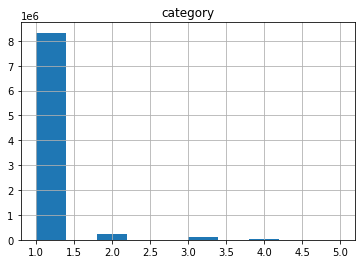

In [10]:
Domains_df.hist(column='category')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f531344f310>]],
      dtype=object)

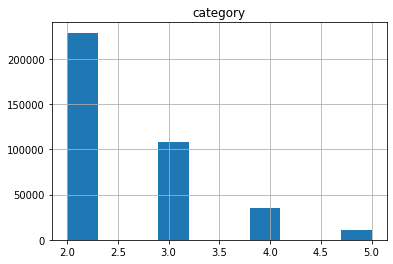

In [11]:
Domains_df.loc[Domains_df['category'] != 1.0].hist(column='category')

# in this figure only 4 classes nazar arhi

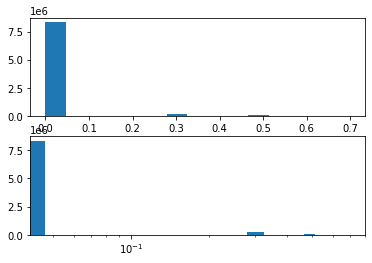

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Domains_df.hist(column='category', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)


# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(np.log10(Domains_df['category']), bins=15)

'''
# histogram on log scale.
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = (np.log10(Domains_df['category']),  bins =15)
'''
plt.subplot(212)
plt.hist(np.log10(Domains_df['category']), bins=15)
plt.xscale('log')
plt.show()

In [16]:
import gc

del Domains_df
gc.get_count()
gc.collect()
gc.get_count()

(26, 0, 0)

In [ ]:
# dfTest = pd.DataFrame(x_train)
# dfTest.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6094575 entries, 0 to 6094574
Columns: 202 entries, 0 to 201
dtypes: float64(202)
memory usage: 9.2 GB


In [17]:
memory_usage()

,Size
x_train,9.57GB
x_test,4.10GB
predicted_test_results,17.01MB
y_train,11.90MB
y_test,5.10MB
_8,8.66KB
___,8.66KB
en_stop,8.23KB
_15,1.28KB
__,1.28KB


In [ ]:
# # feature Scaling

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

# print(x_train)


In [ ]:
# print the shapes of the new X objects
print(x_train.shape)
print(x_test.shape)

(6094575, 200)
(2611961, 200)


In [ ]:
# print the shapes of the new y objects
print(y_train.shape)
print(y_test.shape)

(6094575,)
(2611961,)


# Class Balancing => Class Weights using sklearn

In [ ]:
from sklearn.utils import class_weight
import numpy as np

sk_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

In [ ]:
class_weights = dict(zip(np.unique(y_train), sk_weights))

In [ ]:
class_weights

{1: 0.20917438655204917,
 2: 7.610228010588882,
 3: 16.193256546171934,
 4: 49.432841268553815,
 5: 169.0823970037453}

################################################################################
#Applied different Multi Classifier's Models
################################################################################

##DT Classifier without weights

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
dtree_model = DecisionTreeClassifier(max_depth = 10)
dtree_model = dtree_model.fit(x_train, y_train)
dtree_predictions = dtree_model.predict(x_test)

In [ ]:
from sklearn import metrics #(6 min)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, dtree_predictions, normalize=True)

print("\nAccuracy for the model is ", score)
print("\n\n")

print(metrics.classification_report(y_test, dtree_predictions))
print(metrics.confusion_matrix(y_test, dtree_predictions))



Accuracy for the model is  0.9980964493727127



              precision    recall  f1-score   support

           1       1.00      1.00      1.00   2497400
           2       0.96      0.99      0.98     68644
           3       0.97      0.97      0.97     32260
           4       0.96      0.95      0.96     10568
           5       0.93      0.94      0.93      3089

    accuracy                           1.00   2611961
   macro avg       0.96      0.97      0.97   2611961
weighted avg       1.00      1.00      1.00   2611961

[[2494613    1513     808     330     136]
 [    151   68168     192      94      39]
 [     37     938   31216      37      32]
 [     25     419      19   10089      16]
 [     39     134       6       7    2903]]


In [ ]:
import pickle
 
# Save the trained model as a pickle string.
saved_dtree_model = pickle.dumps(dtree_model)
 
# Load the pickled model
dtree_model_from_pickle = pickle.loads(saved_dtree_model)

##Weighted fit and evaluate DT classifier

In [ ]:
weight_list = []
for index, weight in class_weights.items():
  weight_list.append(weight)

In [ ]:
print(weight_list)

[0.20917438655204917, 7.610228010588882, 16.193256546171934, 49.432841268553815, 169.0823970037453]


In [ ]:
from sklearn.metrics import confusion_matrix   # (1hr & 30min)
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

weighted_model = DecisionTreeClassifier(max_depth = 10, class_weight=class_weights)
weighted_fit = weighted_model.fit(x_train, y_train)

In [ ]:
weighted_dtree_predictions = weighted_fit.predict(x_test)

In [ ]:
# evaluate the model
from sklearn import metrics #(6 min)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, weighted_dtree_predictions, normalize=True)

print("\nAccuracy for the model is ", score)
print("\n\n")

print(metrics.classification_report(y_test, weighted_dtree_predictions))
print(metrics.confusion_matrix(y_test, weighted_dtree_predictions))


Accuracy for the model is  0.998055483983107



              precision    recall  f1-score   support

           1       1.00      1.00      1.00   2497400
           2       0.96      0.99      0.97     68644
           3       0.97      0.97      0.97     32260
           4       0.96      0.95      0.96     10568
           5       0.88      0.95      0.91      3089

    accuracy                           1.00   2611961
   macro avg       0.95      0.97      0.96   2611961
weighted avg       1.00      1.00      1.00   2611961

[[2494605    1512     810     329     144]
 [    128   68071     188      94     163]
 [     32     944   31189      37      58]
 [     16     410      18   10085      39]
 [     13     131       6       7    2932]]


## Save and Load DT Model


In [10]:
import pickle

filename = '/content/drive/MyDrive/ML/Data/WE_DTModel/model.pkl'

In [ ]:
# save the model
pickle.dump(weighted_fit, open(filename, 'wb'))


In [11]:
# load the model
loaded_model = pickle.load(open(filename, 'rb'))


In [19]:
predicted_test_results = loaded_model.predict(X)

In [13]:
y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int16)

In [14]:
def categorize_prediction_level(actual, predicted):
  df = pd.DataFrame()
  df['actual'] = actual
  df['predicted'] = predicted
  df['difference'] = (df['actual'] - df['predicted']).abs()
  # df['error'] = 0 # her error ki category[ 0 - 4 ] kay according - count ker k isi table mein collective amount daal deni hy
  # df.loc[df['difference'] == 1, df['error']] = 1
  # df.loc[df['difference'] == 2, df['error']] = 2
  # df.loc[df['difference'] == 3, df['error']] = 3
  # df.loc[df['difference'] == 4, df['error']] = 4
  return df

In [20]:
error_level_df = categorize_prediction_level(y, predicted_test_results)

In [21]:
error_level_df.head()

,actual,predicted,difference
0,5,5,0
1,1,5,4
2,5,5,0
3,5,5,0
4,5,5,0


In [22]:
error_level_df['difference'].value_counts()

0    8689848
1       9553
2       4614
3       2058
4        463
Name: difference, dtype: int64

##MLP Classifier without weights

In [ ]:
from sklearn.neural_network import MLPClassifier    # (1hr & 21min)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


mlp =MLPClassifier(random_state=1, max_iter=10).fit(x_train, y_train)

mlp.predict_proba(x_test)

mlp_predictions = mlp.predict(x_test)

mlp.score(x_test, y_test)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.



0.956248963901069

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, mlp_predictions))
print(metrics.confusion_matrix(y_test, mlp_predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           1       0.96      1.00      0.98   2497400
           2       0.00      0.00      0.00     68644
           3       0.00      0.00      0.00     32260
           4       0.00      0.00      0.00     10568
           5       0.90      0.10      0.18      3089

    accuracy                           0.96   2611961
   macro avg       0.37      0.22      0.23   2611961
weighted avg       0.92      0.96      0.93   2611961

[[2497375       0       0       0      25]
 [  68641       0       0       0       3]
 [  32256       0       0       0       4]
 [  10567       0       0       0       1]
 [   2779       0       0       0     310]]


In [ ]:
import pickle
 
# Save the trained model as a pickle string.
saved_model = pickle.dumps(mlp)
 
# Load the pickled model
mlp_from_pickle = pickle.loads(saved_model)

##AdaBoost Classifier without weights

In [ ]:
from sklearn.ensemble import AdaBoostClassifier  # (1hr & 30min)
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

#model = DecisionTreeClassifier(criterion='entropy',max_depth=1)
#AdaBoost = AdaBoostClassifier(base_estimator= model,n_estimators=400,learning_rate=1)

AdaBoost = AdaBoostClassifier(n_estimators=10, learning_rate=1, algorithm='SAMME')

Ada_fit = AdaBoost.fit(x_train, y_train)

prediction = AdaBoost.score(x_test, y_test)

print('The accuracy is: ', prediction*100, '%')

The accuracy is:  98.00341582435573 %


In [ ]:
Ada_pred = AdaBoost.predict(x_test)

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, Ada_pred))
print(metrics.confusion_matrix(y_test, Ada_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           1       1.00      1.00      1.00   2497400
           2       0.58      0.95      0.72     68644
           3       0.00      0.00      0.00     32260
           4       0.00      0.00      0.00     10568
           5       0.00      0.00      0.00      3089

    accuracy                           0.98   2611961
   macro avg       0.32      0.39      0.34   2611961
weighted avg       0.97      0.98      0.97   2611961

[[2494609    2791       0       0       0]
 [   3442   65202       0       0       0]
 [   1114   31146       0       0       0]
 [    510   10058       0       0       0]
 [    171    2918       0       0       0]]


In [ ]:
import pickle
 
# Save the trained model as a pickle string.
saved_model = pickle.dumps(AdaBoost)
 
# Load the pickled model
AdaBoost_from_pickle = pickle.loads(saved_model)

In [ ]:
################################ Customise Accuracy - Results below #####################################


In [ ]:
threshold = 3

In [ ]:
#Table that compares between atual and predicted values:
def generate_good_bad_table(y_test, y_pred):
  column_names = ['Actual', 'Predicted', 'Accuracy']
  comparison_df = pd.DataFrame(columns=column_names)

  (np.abs(np.subtract(y_pred, y_test)) - threshold) <= 0

  for ind in range(len(y_test)):
    new_row = {
        column_names[0]: y_test[ind],
        column_names[1]: y_pred[ind],
        column_names[2]: ['Bad', 'Ok'][(np.abs(y_test[ind] - y_pred[ind]) - threshold) <= 0]
    }
    comparison_df = comparison_df.append(new_row, ignore_index=True)

  comparison_df.head(50)


In [ ]:
def get_train_test_accuracy(model, x_train, y_train, x_test, y_test):
  pred_i = model.predict(x_train)
  error_rate = np.mean((np.abs(np.subtract(pred_i, y_train)) - threshold) > 0)
  accuracy = np.mean((np.abs(np.subtract(pred_i, y_train)) - threshold) <= 0)

  print('Train Accuracy is: ', accuracy, '\t error rate is: ', error_rate)

  pred_i = model.predict(x_test)
  error_rate = np.mean((np.abs(np.subtract(pred_i, y_test)) - threshold) > 0)
  accuracy = np.mean((np.abs(np.subtract(pred_i, y_test)) - threshold) <= 0)
  print('Test Accuracy is: ', accuracy, '\t error rate is: ', error_rate)
  #visualize_errors(pred_i, x_train, y_train, x_test, y_test)
  generate_good_bad_table(y_test, pred_i)


In [ ]:
get_train_test_accuracy(loaded_model, x_train, y_train, x_test, y_test)

Train Accuracy is:  0.9999497914128549 	 error rate is:  5.020858714512497e-05
Test Accuracy is:  0.999939891904971 	 error rate is:  6.010809502898397e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



In [ ]:
### Visualizing Errors

def visualize_errors(pred_i, x_train, y_train, x_test, y_test):
  print('Samples correctly classified:')
  correct_idx = np.where((np.abs(np.subtract(pred_i, y_test)) - threshold) <= 0)[0]
  print(correct_idx)

  print('\nSamples incorrectly classified:')
  incorrect_idx = np.where((np.abs(np.subtract(pred_i, y_test)) - threshold) > 0)[0]
  print(incorrect_idx)

  # Plot two dimensions

  #add ten cateogories colors #pending task
  colors = [(1, "red"),(2, "orange"),(3, "indigo"),(4, "seagreen"),(5, "turquoise"),(6, "yellow"),(7, "violet"), (8, "mediumblue"), (9, "palegreen"), (10, "gray")]


  for n, color in colors:
      idx = np.where(y_test == n)[0]
      plt.scatter(x_test[idx, 1], x_test[idx, 2], color=color, label="Class %s" % str(n))

  plt.scatter(x_test[incorrect_idx, 1], x_test[incorrect_idx, 2], color="darkred")

  plt.xlabel('width')
  plt.ylabel('length')
  plt.legend(loc=3)
  plt.title("Classification results")
  plt.show()

  print(pd.crosstab(y_test, pred_i, rownames=['Real'], colnames=['Predicted'], margins=True, margins_name='total'))

  # Evaluating the Algorithm
  from sklearn.metrics import classification_report, confusion_matrix

  print(confusion_matrix(y_test, pred_i))
  print("\n")
  print(classification_report(y_test, pred_i))


In [ ]:

def get_train_test_accuracy(model, x_train, y_train, x_test, y_test):
  pred_i = model.predict(x_train)
  error_rate = np.mean((np.abs(np.subtract(pred_i, y_train)) - threshold) > 0)
  accuracy = np.mean((np.abs(np.subtract(pred_i, y_train)) - threshold) <= 0)

  print('Train Accuracy is: ', accuracy, '\t error rate is: ', error_rate)

  pred_i = model.predict(x_test)
  error_rate = np.mean((np.abs(np.subtract(pred_i, y_test)) - threshold) > 0)
  accuracy = np.mean((np.abs(np.subtract(pred_i, y_test)) - threshold) <= 0)
  print('Test Accuracy is: ', accuracy, '\t error rate is: ', error_rate)
  visualize_errors(pred_i, x_train, y_train, x_test, y_test)
  generate_good_bad_table(y_test, pred_i)
  

Train Accuracy is:  0.9999977028750979 	 error rate is:  2.297124902064541e-06
Test Accuracy is:  0.9999965543130238 	 error rate is:  3.4456869761837944e-06
Samples correctly classified:
[      0       1       2 ... 2611958 2611959 2611960]

Samples incorrectly classified:
[ 690207  990346 1471374 1920431 1921957 1923468 2000425 2219663 2515535]


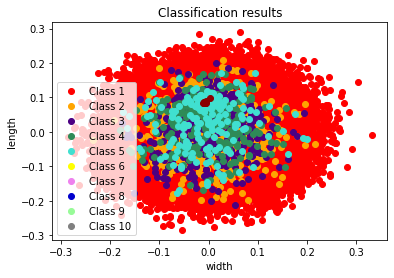

Predicted        1      2      3    total
Real                                     
1          2494609   1506   1285  2497400
2              128  68195    321    68644
3               31   1116  31113    32260
4               11    508  10049    10568
5                9    168   2912     3089
total      2494788  71493  45680  2611961
[[2494609    1506    1285       0       0]
 [    128   68195     321       0       0]
 [     31    1116   31113       0       0]
 [     11     508   10049       0       0]
 [      9     168    2912       0       0]]




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



              precision    recall  f1-score   support

           1       1.00      1.00      1.00   2497400
           2       0.95      0.99      0.97     68644
           3       0.68      0.96      0.80     32260
           4       0.00      0.00      0.00     10568
           5       0.00      0.00      0.00      3089

    accuracy                           0.99   2611961
   macro avg       0.53      0.59      0.55   2611961
weighted avg       0.99      0.99      0.99   2611961



In [ ]:
get_train_test_accuracy(loaded_model, x_train, y_train, x_test, y_test)

In [ ]:
##################################################################
#Check Accuracy Score
print('Default Accuracy: {}'.format(round(AdaBoost.score(x_test, y_test), 3)))

print('Custom Accuracy: {}'.format(round(np.mean((np.abs(np.subtract(pred_i, y_test)) - threshold) <= 0))))

print("\nminimum error:-", min(error_rate), "at k = ", error_rate.index(min(error_rate))+1)
##################################################################

Default Accuracy: 0.98


NameError: ignored